In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import os
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 读取csv文件
data = pd.read_csv('/mnt/workspace/NewFaceEmotion/data/fer2013.csv')
bs = 128

# 根据Usage列将数据分为训练集和测试集
train_data = data[data['Usage'] == 'Training']
test_data = data[data['Usage'].isin(['PublicTest', 'PrivateTest'])]

# 创建自定义Dataset类
class EmotionDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = self.data.iloc[index]['emotion']
        imgs = self.data.iloc[index]['pixels']
        imgs = np.array(imgs.split(), dtype='uint8').reshape(48,48)
        imgs = imgs[:, :, np.newaxis]
        imgs = np.concatenate((imgs, imgs, imgs), axis=2)
        imgs = Image.fromarray(imgs)
        if self.transform:
            imgs = self.transform(imgs)
        return imgs, label

transform_train = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(44),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
])
# 创建训练集和测试集的DataLoader
train_dataset = EmotionDataset(train_data, transform=transform_train)
test_dataset = EmotionDataset(test_data, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# for batch_idx, (inputs, targets) in enumerate(train_loader):
#     print(inputs.shape)
# for batch_idx, (inputs, targets) in enumerate(test_loader):
#     print(inputs.shape)
#print(train_loader[0][0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7

# 创建单通道vgg-19模型
class SelfVgg(nn.Module):
    def __init__(self):
        super(SelfVgg, self).__init__()
        tradition_vgg = models.vgg19(pretrained=False)  
        # 加载预训练的vgg-19模型
        #tradition_vgg.load_state_dict(torch.load(vgg19_model_path))
        
        # 只取卷积层
        self.features = tradition_vgg.features
        # 添加自定义的全连接层进行7分类
        self.classifier = nn.Linear(512, 7)
    

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

# 使用单通道预训练的vgg模型
vgg19 = SelfVgg()

vgg19 = vgg19.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(vgg19.parameters()) , lr=0.01, momentum=0.9, weight_decay=5e-4)
num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # 使用VGG19进行训练
        outputs_vgg19 = model(images)
        loss_vgg19 = criterion(outputs_vgg19, labels)
        optimizer.zero_grad()
        loss_vgg19.backward()
        optimizer.step()
        train_loss += loss_vgg19.item()
        _, predicted = torch.max(outputs_vgg19.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        if(i+1)%100 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), loss_vgg19.item()))
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / total)
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))    
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            #print(type(images))
            #print(images)
            #print(images.shape)
            #bs, ncrops, c, h, w = np.shape(images)
            images, labels = images.to(device), labels.to(device)
            #print(type(images))
            images = images.view(-1, 3, 44, 44)
            output = model(images)
            print(output.shape)
            output_avg = torch.stack(output.chunk(10, dim=0)).mean(dim=0)
            #output_avg = output.view(bs, 10, -1).mean(1)  # avg over crops
            #loss_vgg19 = criterion(output, labels)
            loss_vgg19 = criterion(output_avg, labels)
            test_loss += loss_vgg19.item() # 将一批的损失相加
            #_, predicted = torch.max(output.data, 1) # 找到概率最大的下标
            _, predicted = torch.max(output_avg.data, 1) # 找到概率最大的下标
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_correct / total)
 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset),
        100. * test_correct / len(test_loader.dataset)))

for epoch in range(1, num_epochs + 1):
    train(vgg19, device, train_loader, optimizer, epoch)
    test(vgg19, device, test_loader)
    
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/home/pai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/pai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 1 [12672/28709 (44%)]	Loss: 1.797106
Train Epoch: 1 [25472/28709 (88%)]	Loss: 1.780356

Train set: Average loss: 411.3316, Accuracy: 7077/28709 (25%)

torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])
torch.Size([1280, 7])


KeyboardInterrupt: 

/home/pai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/pai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 1 [12672/28709 (44%)]	Loss: 1.834799
Train Epoch: 1 [25472/28709 (88%)]	Loss: 1.804011

Train set: Average loss: 410.6662, Accuracy: 7087/28709 (25%)


Test set: Average loss: 103.3152, Accuracy: 1774/7178 (25%)

Train Epoch: 2 [12672/28709 (44%)]	Loss: 1.804208
Train Epoch: 2 [25472/28709 (88%)]	Loss: 1.774343

Train set: Average loss: 407.0863, Accuracy: 7215/28709 (25%)


Test set: Average loss: 102.7913, Accuracy: 1774/7178 (25%)

Train Epoch: 3 [12672/28709 (44%)]	Loss: 1.778014
Train Epoch: 3 [25472/28709 (88%)]	Loss: 1.748727

Train set: Average loss: 401.0494, Accuracy: 7478/28709 (26%)


Test set: Average loss: 100.7664, Accuracy: 2012/7178 (28%)

Train Epoch: 4 [12672/28709 (44%)]	Loss: 1.698920
Train Epoch: 4 [25472/28709 (88%)]	Loss: 1.704975

Train set: Average loss: 379.7324, Accuracy: 9385/28709 (33%)


Test set: Average loss: 90.0994, Accuracy: 2694/7178 (38%)

Train Epoch: 5 [12672/28709 (44%)]	Loss: 1.609871
Train Epoch: 5 [25472/28709 (88%)]	Loss: 1.5617

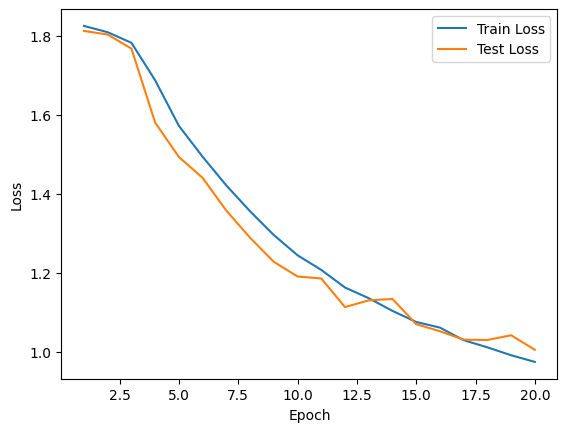

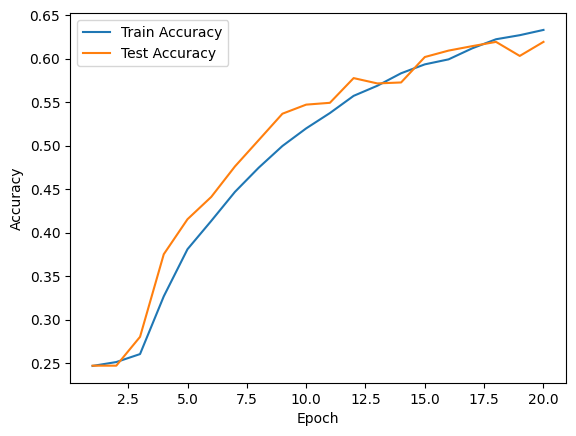

In [5]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import os
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 读取csv文件
data = pd.read_csv('/mnt/workspace/NewFaceEmotion/data/fer2013.csv')
bs = 128

# 根据Usage列将数据分为训练集和测试集
train_data = data[data['Usage'] == 'Training']
test_data = data[data['Usage'].isin(['PublicTest', 'PrivateTest'])]

# 创建自定义Dataset类
class EmotionDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = self.data.iloc[index]['emotion']
        imgs = self.data.iloc[index]['pixels']
        imgs = np.array(imgs.split(), dtype='uint8').reshape(48,48)
        imgs = imgs[:, :, np.newaxis]
        imgs = np.concatenate((imgs, imgs, imgs), axis=2)
        imgs = Image.fromarray(imgs)
        if self.transform:
            imgs = self.transform(imgs)
        return imgs, label

transform_train = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(44),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
])
# 创建训练集和测试集的DataLoader
train_dataset = EmotionDataset(train_data, transform=transform_train)
test_dataset = EmotionDataset(test_data, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# for batch_idx, (inputs, targets) in enumerate(train_loader):
#     print(inputs.shape)
# for batch_idx, (inputs, targets) in enumerate(test_loader):
#     print(inputs.shape)
#print(train_loader[0][0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7

# 创建单通道vgg-19模型
class SelfVgg(nn.Module):
    def __init__(self):
        super(SelfVgg, self).__init__()
        tradition_vgg = models.vgg19(pretrained=False)  
        # 加载预训练的vgg-19模型
        #tradition_vgg.load_state_dict(torch.load(vgg19_model_path))
        
        # 只取卷积层
        self.features = tradition_vgg.features
        # 添加自定义的全连接层进行7分类
        self.classifier = nn.Linear(512, 7)
    

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

# 使用单通道预训练的vgg模型
vgg19 = SelfVgg()

vgg19 = vgg19.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(vgg19.parameters()) , lr=0.01, momentum=0.9, weight_decay=5e-4)
num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # 使用VGG19进行训练
        outputs_vgg19 = model(images)
        loss_vgg19 = criterion(outputs_vgg19, labels)
        optimizer.zero_grad()
        loss_vgg19.backward()
        optimizer.step()
        train_loss += loss_vgg19.item()
        _, predicted = torch.max(outputs_vgg19.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        if(i+1)%100 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), loss_vgg19.item()))
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / total)
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))    
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            #print(type(images))
            #print(images)
            #print(images.shape)
            bsn, ncrops, c, h, w = np.shape(images)
            images, labels = images.to(device), labels.to(device)
            #print(type(images))
            images = images.view(-1, 3, 44, 44)
            output = model(images)
            #print(output.shape)
            #output_avg = torch.stack(output.chunk(10, dim=0)).mean(dim=0)
            #print(output_avg)
            output_avg = output.view(bsn, 10, -1).mean(1)  # avg over crops
            #loss_vgg19 = criterion(output, labels)
            loss_vgg19 = criterion(output_avg, labels)
            test_loss += loss_vgg19.item() # 将一批的损失相加
            #_, predicted = torch.max(output.data, 1) # 找到概率最大的下标
            _, predicted = torch.max(output_avg.data, 1) # 找到概率最大的下标
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_correct / total)
 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset),
        100. * test_correct / len(test_loader.dataset)))

for epoch in range(1, num_epochs + 1):
    train(vgg19, device, train_loader, optimizer, epoch)
    test(vgg19, device, test_loader)
    
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/home/pai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/pai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 1 [12672/28709 (44%)]	Loss: 1.431638
Train Epoch: 1 [25472/28709 (88%)]	Loss: 1.219149

Train set: Average loss: 317.4783, Accuracy: 13012/28709 (45%)


Test set: Average loss: 70.5017, Accuracy: 3743/7178 (52%)

Train Epoch: 2 [12672/28709 (44%)]	Loss: 1.341107
Train Epoch: 2 [25472/28709 (88%)]	Loss: 1.171768

Train set: Average loss: 264.2107, Accuracy: 15978/28709 (56%)


Test set: Average loss: 61.3503, Accuracy: 4224/7178 (59%)

Train Epoch: 3 [12672/28709 (44%)]	Loss: 0.992360
Train Epoch: 3 [25472/28709 (88%)]	Loss: 0.927355

Train set: Average loss: 242.6067, Accuracy: 17112/28709 (60%)


Test set: Average loss: 59.6948, Accuracy: 4341/7178 (60%)

Train Epoch: 4 [12672/28709 (44%)]	Loss: 1.085725
Train Epoch: 4 [25472/28709 (88%)]	Loss: 1.167341

Train set: Average loss: 229.4485, Accuracy: 17859/28709 (62%)


Test set: Average loss: 57.8148, Accuracy: 4427/7178 (62%)

Train Epoch: 5 [12672/28709 (44%)]	Loss: 0.989245
Train Epoch: 5 [25472/28709 (88%)]	Loss: 0.953

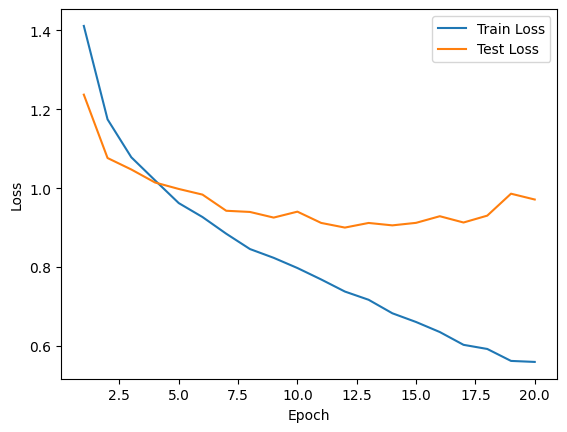

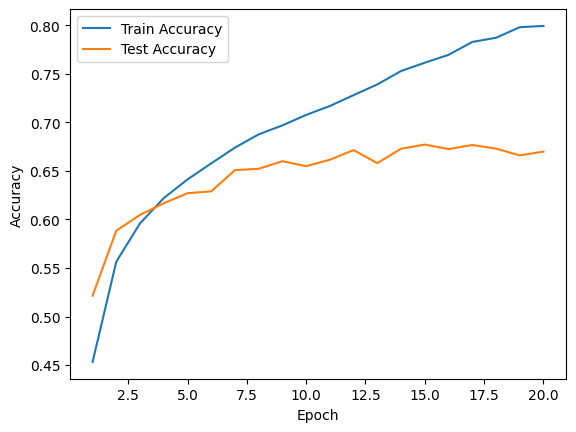

In [6]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import os
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 读取csv文件
data = pd.read_csv('/mnt/workspace/NewFaceEmotion/data/fer2013.csv')
bs = 128
lr_start = 0.01

# 根据Usage列将数据分为训练集和测试集
train_data = data[data['Usage'] == 'Training']
test_data = data[data['Usage'].isin(['PublicTest', 'PrivateTest'])]

# 创建自定义Dataset类
class EmotionDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = self.data.iloc[index]['emotion']
        imgs = self.data.iloc[index]['pixels']
        imgs = np.array(imgs.split(), dtype='uint8').reshape(48,48)
        imgs = imgs[:, :, np.newaxis]
        imgs = np.concatenate((imgs, imgs, imgs), axis=2)
        imgs = Image.fromarray(imgs)
        if self.transform:
            imgs = self.transform(imgs)
        return imgs, label

transform_train = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(44),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
])
# 创建训练集和测试集的DataLoader
train_dataset = EmotionDataset(train_data, transform=transform_train)
test_dataset = EmotionDataset(test_data, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

vgg19_model_path = '/mnt/workspace/PublicModels/vgg19.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7

# 创建单通道vgg-19模型
class SelfVgg(nn.Module):
    def __init__(self):
        super(SelfVgg, self).__init__()
        tradition_vgg = models.vgg19(pretrained=False)  
        # 加载预训练的vgg-19模型
        tradition_vgg.load_state_dict(torch.load(vgg19_model_path))
        
        # 只取卷积层
        self.features = tradition_vgg.features
        # 添加自定义的全连接层进行7分类
        self.classifier = nn.Linear(512, 7)
    

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

# 使用单通道预训练的vgg模型
vgg19 = SelfVgg()

vgg19 = vgg19.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(vgg19.parameters()) , lr=lr_start, momentum=0.9, weight_decay=5e-4)
num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # 使用VGG19进行训练
        outputs_vgg19 = model(images)
        loss_vgg19 = criterion(outputs_vgg19, labels)
        optimizer.zero_grad()
        loss_vgg19.backward()
        optimizer.step()
        train_loss += loss_vgg19.item()
        _, predicted = torch.max(outputs_vgg19.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        if(i+1)%100 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), loss_vgg19.item()))
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / total)
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))    
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            bsn, ncrops, c, h, w = np.shape(images)
            images, labels = images.to(device), labels.to(device)
            #print(type(images))
            images = images.view(-1, 3, 44, 44)
            output = model(images)
            output_avg = output.view(bsn, 10, -1).mean(1)  # avg over crops
            #loss_vgg19 = criterion(output, labels)
            loss_vgg19 = criterion(output_avg, labels)
            test_loss += loss_vgg19.item() # 将一批的损失相加
            _, predicted = torch.max(output_avg.data, 1) # 找到概率最大的下标
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_correct / total)
 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset),
        100. * test_correct / len(test_loader.dataset)))

for epoch in range(1, num_epochs + 1):
    train(vgg19, device, train_loader, optimizer, epoch)
    test(vgg19, device, test_loader)
    
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/home/pai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/pai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


learning_rate: 0.01
Train Epoch: 1 [12672/28709 (44%)]	Loss: 1.370055
Train Epoch: 1 [25472/28709 (88%)]	Loss: 1.138447

Train set: Average loss: 334.7289, Accuracy: 12021/28709 (42%)
Test set: Average loss: 68.9335, Accuracy: 3885/7178 (54%)

learning_rate: 0.01
Train Epoch: 2 [12672/28709 (44%)]	Loss: 1.247168
Train Epoch: 2 [25472/28709 (88%)]	Loss: 1.114748

Train set: Average loss: 264.8027, Accuracy: 15852/28709 (55%)
Test set: Average loss: 64.2998, Accuracy: 4159/7178 (58%)

learning_rate: 0.01
Train Epoch: 3 [12672/28709 (44%)]	Loss: 1.160246
Train Epoch: 3 [25472/28709 (88%)]	Loss: 1.021233

Train set: Average loss: 244.1744, Accuracy: 16996/28709 (59%)
Test set: Average loss: 61.6566, Accuracy: 4260/7178 (59%)

learning_rate: 0.01
Train Epoch: 4 [12672/28709 (44%)]	Loss: 0.876811
Train Epoch: 4 [25472/28709 (88%)]	Loss: 1.067982

Train set: Average loss: 228.7875, Accuracy: 17772/28709 (62%)
Test set: Average loss: 58.1280, Accuracy: 4400/7178 (61%)

learning_rate: 0.01
Trai

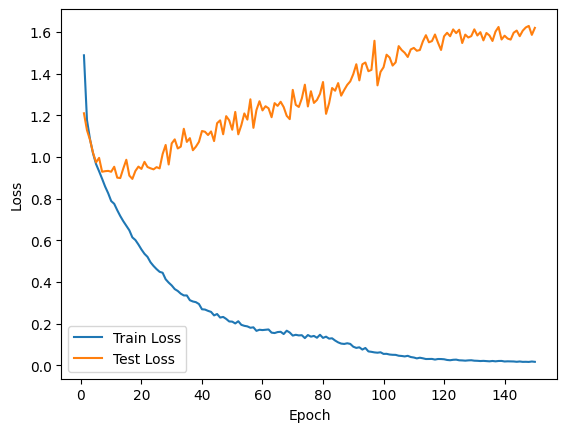

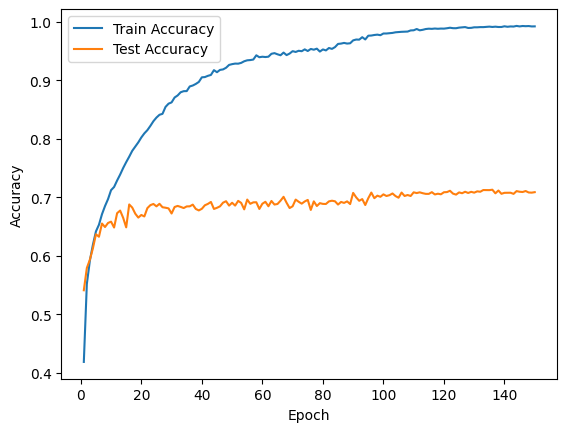

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import os
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 读取csv文件
data = pd.read_csv('/mnt/workspace/NewFaceEmotion/data/fer2013.csv')
bs = 128
lr_start = 0.01

# 根据Usage列将数据分为训练集和测试集
train_data = data[data['Usage'] == 'Training']
test_data = data[data['Usage'].isin(['PublicTest', 'PrivateTest'])]

# 创建自定义Dataset类
class EmotionDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = self.data.iloc[index]['emotion']
        imgs = self.data.iloc[index]['pixels']
        imgs = np.array(imgs.split(), dtype='uint8').reshape(48,48)
        imgs = imgs[:, :, np.newaxis]
        imgs = np.concatenate((imgs, imgs, imgs), axis=2)
        imgs = Image.fromarray(imgs)
        if self.transform:
            imgs = self.transform(imgs)
        return imgs, label

transform_train = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    # 十裁切
    transforms.TenCrop(44),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
])
# 创建训练集和测试集的DataLoader
train_dataset = EmotionDataset(train_data, transform=transform_train)
test_dataset = EmotionDataset(test_data, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

vgg19_model_path = '/mnt/workspace/PublicModels/vgg19.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7

# 创建单通道vgg-19模型
class SelfVgg(nn.Module):
    def __init__(self):
        super(SelfVgg, self).__init__()
        tradition_vgg = models.vgg19(pretrained=False)  
        # 加载预训练的vgg-19模型
        tradition_vgg.load_state_dict(torch.load(vgg19_model_path))
        
        # 只取卷积层
        self.features = tradition_vgg.features
        # 添加自定义的全连接层进行7分类
        self.classifier = nn.Linear(512, 7)
    
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

# 使用单通道预训练的vgg模型
vgg19 = SelfVgg()

vgg19 = vgg19.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(list(vgg19.parameters()) , lr=lr_start, momentum=0.9, weight_decay=5e-4)
num_epochs = 150

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

learning_rate_decay_start = 80  # 50
learning_rate_decay_every = 5 # 5
learning_rate_decay_rate = 0.9 # 0.9

# 修改学习率
def set_lr(optimizer, lr):
    for group in optimizer.param_groups:
        group['lr'] = lr

# 梯度裁切，避免梯度爆炸
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            param.grad.data.clamp_(-grad_clip, grad_clip)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total = 0
    
    # 学习率衰减
    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr =  lr_start * decay_factor
        set_lr(optimizer, current_lr)  # set the decayed rate
    else:
        current_lr = lr_start
    print('learning_rate: %s' % str(current_lr))
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # 使用VGG19进行训练
        outputs_vgg19 = model(images)
        loss_vgg19 = criterion(outputs_vgg19, labels)
        optimizer.zero_grad()
        loss_vgg19.backward()
        clip_gradient(optimizer, 0.1)
        optimizer.step()
        train_loss += loss_vgg19.item()
        _, predicted = torch.max(outputs_vgg19.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        if(i+1)%100 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), loss_vgg19.item()))
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / total)
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))    
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            bsn, ncrops, c, h, w = np.shape(images)
            images, labels = images.to(device), labels.to(device)
            #print(type(images))
            images = images.view(-1, 3, 44, 44)
            output = model(images)
            output_avg = output.view(bsn, 10, -1).mean(1)  # avg over crops
            loss_vgg19 = criterion(output_avg, labels)
            test_loss += loss_vgg19.item() # 将一批的损失相加
            _, predicted = torch.max(output_avg.data, 1) # 找到概率最大的下标
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_correct / total)
 
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset),
        100. * test_correct / len(test_loader.dataset)))

for epoch in range(1, num_epochs + 1):
    train(vgg19, device, train_loader, optimizer, epoch)
    test(vgg19, device, test_loader)
# 可视化    
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()